In [73]:
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

from scipy import stats
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from formulaic import model_matrix
from sklearn.datasets import load_wine
from sklearn.model_selection import GridSearchCV


In [74]:
wine = load_wine(as_frame=True)
dir(wine)
wine.frame

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [75]:
wine.data.columns = ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od315_of_diluted_wines', 'proline']

In [110]:
X = wine.data[wine.data.columns[1::]]
y = wine.data["alcohol"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

## MODELO 1

In [111]:
formula = ' ~ malic_acid + ash + alcalinity_of_ash + magnesium + total_phenols + flavanoids + nonflavanoid_phenols + proanthocyanins + color_intensity + od315_of_diluted_wines + hue + proline'
X_train1 = model_matrix(formula, data=X_train)
X_test1 = model_matrix(formula, data=X_test)

In [112]:
alphas = np.logspace(-4,4,100)
alpha = {"alpha": alphas}

In [113]:
gs = GridSearchCV(
    Ridge(),
    alpha,
    cv=5,
    scoring = "neg_root_mean_squared_error",
    return_train_score = True,
)

gs.fit(X_train1, y_train)

gs.best_params_, gs.best_index_, (-1)*gs.best_score_

({'alpha': 25.950242113997373}, 67, 0.5246932866552931)

In [114]:
cv_results_ = pd.DataFrame(gs.cv_results_)[["param_alpha", "mean_test_score", "mean_train_score"]]
cv_results_[["mean_test_score", "mean_train_score"]] *= -1

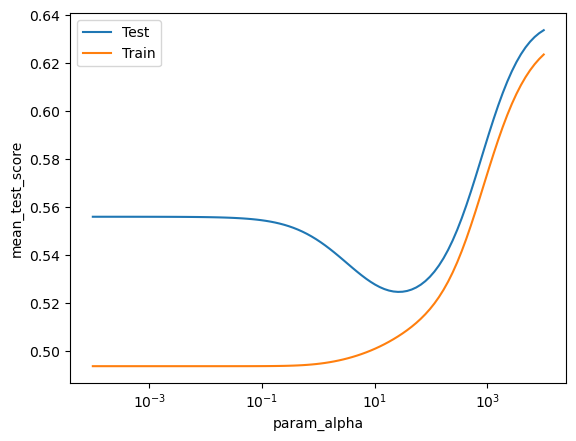

In [115]:
sns.lineplot(x="param_alpha", y="mean_test_score", data=cv_results_, label="Test")
sns.lineplot(x="param_alpha", y="mean_train_score", data=cv_results_, label="Train")
plt.xscale("log")
plt.show()

In [116]:
y_pred = gs.predict(X_test1)
recm = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test: {recm} \nTrain: {(-1)*gs.best_score_}")

Test: 0.581634398183901 
Train: 0.5246932866552931


In [117]:
wine2 = X_test1.copy()
wine2["alcohol"] = y_test
wine2["prediccion"] = y_pred 
wine2["residuos"] = wine2["alcohol"] - wine2["prediccion"]
wine2["residuos"]

25     0.388245
36     0.070530
7      0.332978
82    -0.049439
38    -0.106177
73     0.463731
68     0.723661
5      0.053583
47     0.373435
60    -0.280441
11     0.520362
46     0.720043
127   -0.224075
112   -0.985394
126    0.146483
136   -0.697496
52    -0.181899
67    -0.267322
19     0.176644
161    0.590987
167   -1.008556
144   -1.527197
56     0.697027
151   -0.706550
102   -0.001954
129   -0.565282
134   -0.280631
166   -0.320740
44    -0.158507
149   -0.443383
70    -0.322397
6      0.587408
142    0.933593
72     1.194855
64    -0.017271
147   -0.573843
Name: residuos, dtype: float64

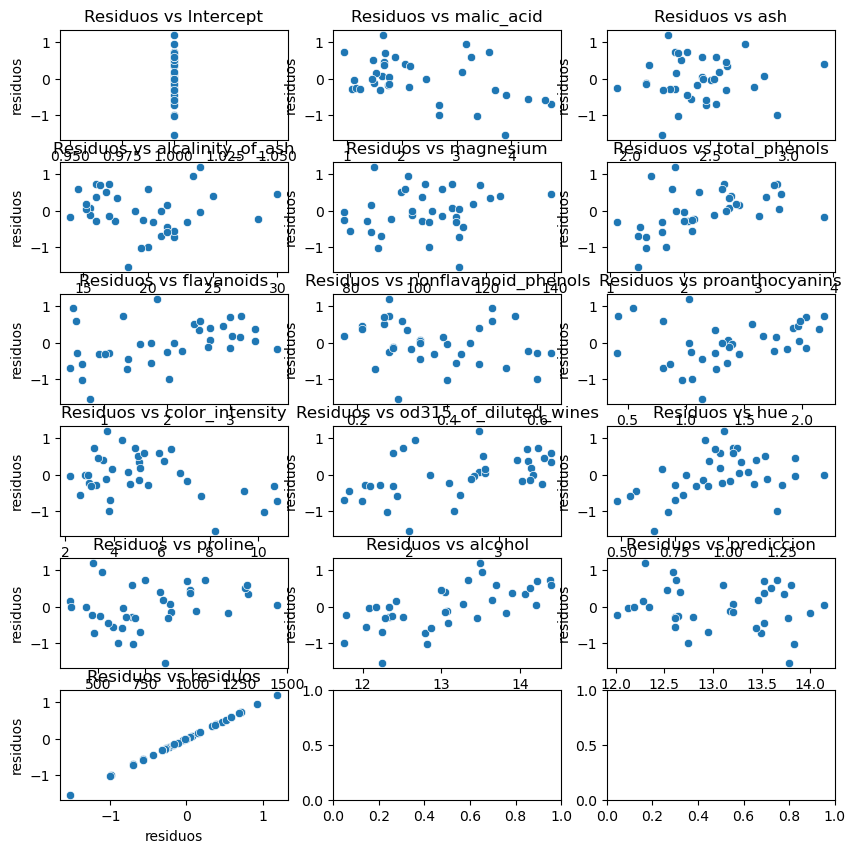

In [118]:
fig, axs = plt.subplots(6, 3, figsize = (10, 10))
for versus, ax in zip(wine2.columns, axs.flatten()):
    sns.scatterplot(x=versus, y="residuos", data=wine2, ax=ax).set_label(None)
    ax.set_title(f"Residuos vs {versus}")

<AxesSubplot: xlabel='alcohol', ylabel='prediccion'>

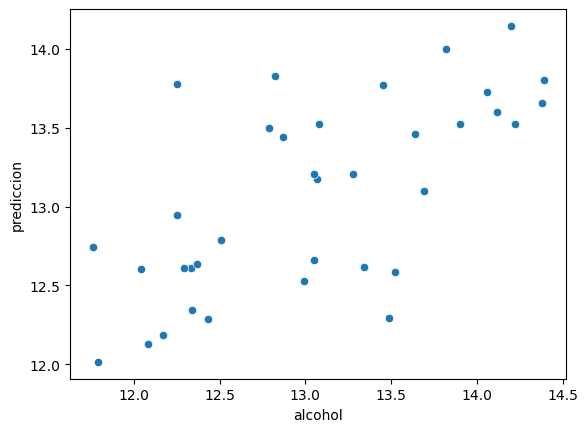

In [119]:
sns.scatterplot(data = wine2, x = "alcohol", y = "prediccion")

In [120]:
m_al = wine.data["alcohol"].mean()
m_res = wine2["prediccion"].mean()
print(f"Diferencial proporcional de media de predicciones respecto de alcohol: {m_res/m_al*100}%")

Diferencial proporcional de media de predicciones respecto de alcohol: 100.54543226966015%


Los residuos parecen no tener estructura por sobre ningun dato respecto del modelo, las predicciones tienen un porcentaje de similitud a los datos de practicamente 100% (respecto de los datos totales) y la raiz del error cuadratico medio es de 0.5 para los datos de test. Por lo tanto tiene sentido decir que este modelo es todo un exito.